In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import allel
os.environ['R_USER'] = 'D:\Anaconda3\Lib\site-packages\rpy2'
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
import rpy2.robjects.numpy2ri as rpyn
pandas2ri.activate()

plt.style.use('ggplot')



In [166]:
home = os.path.expanduser('~')
directory = os.path.join('Imp_Research','Dataset')

pop_name = 'BFcol.3R'

# ignore 3L choromosome for now
filename = f'haplotype.intergenic.{pop_name}.Rdata'
data_path = os.path.join(home, directory, filename)

data = robjects.r['load'](data_path)
data

R object with classes: ('character',) mapped to:
<StrVector - Python:0x7f4ce8ea3e08 / R:0x563db7b7b1d8>
['haplotype', 'POS']

In [88]:
type(robjects.r['haplotype'])

Type :  <class 'rpy2.robjects.vectors.Matrix'>


In [194]:
# taking the transpose
haplotype = np.array(robjects.r['haplotype']).T
haplo_len = len(haplotype)
haplotype.shape

(4836295, 150)

In [195]:
POS = np.array(robjects.r['POS'])
POS.shape

(4836295,)

In [208]:
# def all_filters(self, LD_window_size, LD_overlap_step, MBP_start = 1, MBP_end = 37, MAF_threshold = 5, LD_threshold=.1,LD_iter=1):

bfcol = FilterSNP(haplotype,POS)
bfcol_H,bfcol_P = bfcol.all_filters(LD_window_size = 500,LD_overlap_step = 100,LD_iter = 3)

1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 150)
2.) Filtering Rare Allels
Number of SNPs removed =  3450127
Retaining =  201593
3.) Performing LD Pruning
iteration 1 retaining 94486 removing 107107 variants
Retained Matrix =  (94486, 150)


### Coverting Datasets from Rdata to HDF5 
#### Removes a lot of dependencies. We only need Pandas

In [7]:
'''
Converting from Rdata and saving datasets in HDF5 format with compression.
Naming : key1.key2.Population.arm.hd5
e.g, Haplotype.POS.BFcol.3L.hd5

Preferrably use as a .py script in terminal for efficiency.
'''

populations = ['BFcol','BFgam','AOcol','CIcol','CMgam','FRgam',
              'GAgam','GHcol','GHgam','GM','GNcol','GNgam','GQgam',
              'GW','KE','UGgam']
chromo_arms = ['3R','3L']
for population in populations:
    for arm in chromo_arms:
        
        pop_name = population+'.'+arm
        filename = f'haplotype.intergenic.{pop_name}.Rdata'
        data_path = os.path.join(home, directory, filename)
        store_path = os.path.join(home,directory,"HDF_Dataset")

        data = robjects.r['load'](data_path)
        # storing transpose of Haplotype because sk-allel takes SNP x samples as input
        haplotype = np.array(robjects.r['haplotype'],dtype=np.uint8).T
        POS = np.array(robjects.r['POS'])

        # To read the dataset, keys present in name can be used : 'Haplotype' and 'POS'
        storefile = os.path.join(store_path, f'Haplotype.POS.{pop_name}.hd5')
        hap = pd.DataFrame(haplotype).astype('int8')
        pos = pd.DataFrame(POS)
        # To prevent out of memory error Delete the variables
        del haplotype, POS
        hap.to_hdf(storefile,key='Haplotype',format='fixed',mode='w',complevel=9)
        del hap
        pos.to_hdf(storefile,key='POS',format='fixed',mode='a',complevel=9)
        del pos


KeyboardInterrupt: 

In [13]:
# CMgam couldn't be loaded via R packages available for Python

data_path1 = os.path.join(home, directory, 'CMgam.3R.1.RData')
data_path2 = os.path.join(home, directory, 'CMgam.3R.2.RData')
data_path3 = os.path.join(home, directory, 'CMgam.3R.3.RData')

data1 = robjects.r['load'](data_path1)
print(data1)
H = np.array(robjects.r['haplotype1'],dtype=np.uint8).T
P = np.array(robjects.r['POS1'])

print(H.shape, P.shape)

data2 = robjects.r['load'](data_path2)
print(data2)
H = np.append(H,np.array(robjects.r['haplotype1'],dtype=np.uint8).T,axis = 1)

print(H.shape, P.shape)

data3 = robjects.r['load'](data_path3)
print(data3)
H = np.append(H,np.array(robjects.r['haplotype1'],dtype=np.uint8).T,axis =1)
# P = np.append(P,robjects.r['POS1'],axis=1)

print(H.shape, P.shape)

store_path = os.path.join(home,directory,"HDF_Dataset")
storefile = os.path.join(store_path, f'Haplotype.POS.CMgam.3R.hd5')
hap = pd.DataFrame(H).astype('int8')
pos = pd.DataFrame(P)
print(hap.shape," ",pos.shape)
# To prevent out of memory error Delete the variables
del H,P
hap.to_hdf(storefile,key='Haplotype',format='fixed',mode='w',complevel=9)
del hap
pos.to_hdf(storefile,key='POS',format='fixed',mode='a',complevel=9)
del pos

[1] "haplotype1" "POS1"      

(4836295, 200) (4836295,)
[1] "haplotype1" "POS1"      

(4836295, 400) (4836295,)
[1] "haplotype1" "POS1"      

(4836295, 594) (4836295,)
(4836295, 594)   (4836295, 1)


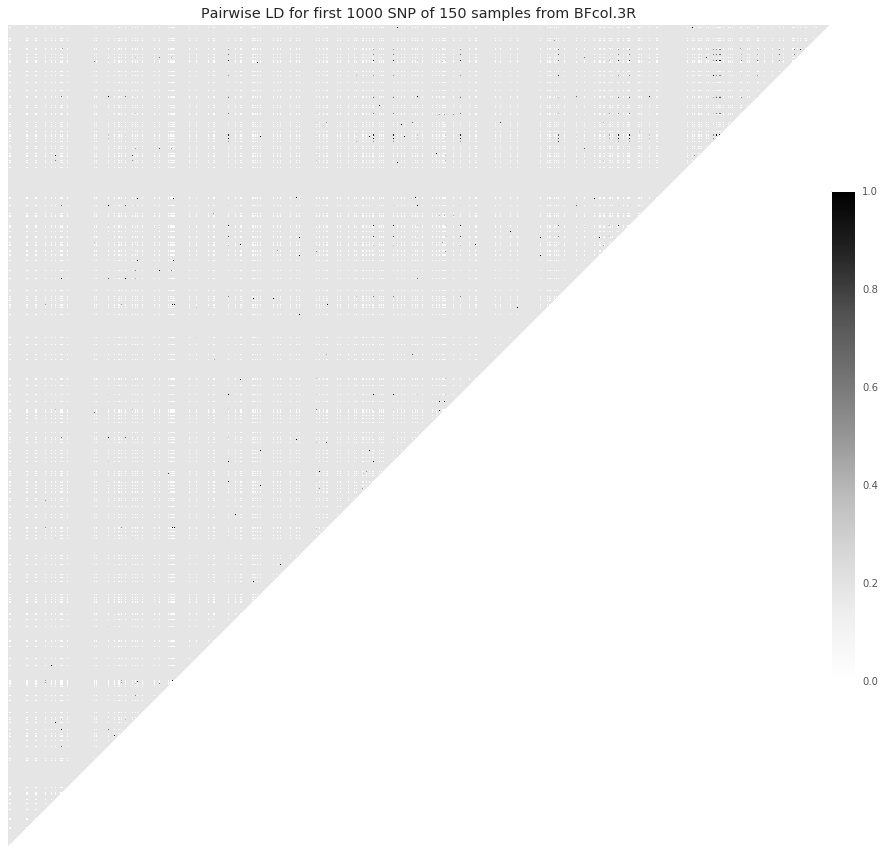

In [186]:
# Funtion definitions are changed in scikit-allel 
# refer the documentation before using the code
def plot_ld(gn, title):
    m = allel.rogers_huff_r(gn)**2
    ax = allel.plot_pairwise_ld(m)
    ax.set_title(title)
plot_ld(haplotype[:1000], 'Pairwise LD for first 1000 SNP of 150 samples from BFcol.3R')

### Selecting 1-37MBP

In [169]:
'''
get_MBP()
Funtction takes in POS array, start and end Mega Base Pair 
return : Indices of the MBPs
'''
# runs in 12.6 seconds
# def get_MBP(POS,start = 1,end = 37):
#     index = []
#     for i in range(len(POS)):
#         if POS[i] > 1000000 and POS[i] <= 37000000:
#             index.append(i)
#     return index

# Library function runs in 0.16 seconds

def get_MBP(POS,start = 1,end = 37):
    return np.where(POS[np.where(POS>=1e6)]<=37e6)[0]

# import timeit
# start = timeit.default_timer()
# index = get_MBP2(POS)
# stop = timeit.default_timer()
# print(stop-start)
# >>> 0.16424157
'''
get_haplo_MBP()
takes a haplotype matrix and POS 
returns haplotype matrix with only selected MBP positions, POS
'''
def get_haplo_MBP(haplotype,POS,start = 1,end = 37):
    index = get_MBP(POS,start,end)
    return np.take(haplotype,index,0),np.take(POS,index,0)


In [170]:
haplotypeF,POSF = get_haplo_MBP(haplotype,POS)
haplotypeF.shape
# 3651720 SNPs are left

(3651720, 150)

In [171]:
POSF.shape

(3651720,)

### Filtering SNPs with Rare Allele using Minor Allel Frequency (MAF)

In [161]:
'''
The function removes the rare allel using minor frequency threshold.
MFA means an allel with lower relative count. MAF0 = Count(0)/Total
if MAF > 0.5 then its major otherwise minor, and vice versa.

Params: Haplotype Matrix, Threshold in percent
return : Filtered Haplotype Matrix,POS
'''

def filter_MAF(haplo,threshold = 5):
    if threshold >= 50 : 
        print("MAF threshold cannot be more than 49%")
        return
    samples = haplo.shape[1]
    sums = haplo.sum(axis=1)
    maf = get_MAF(haplo)
    #indexes = np.where(maf >= threshold*0.01)[0]
    minor = samples*threshold/100
    major = samples*(100-threshold)/100
    # Selects indexes where allels are >threshold or all 0 and all 1.
    indexes = np.where((sums>=minor)& (sums<=major))[0]
    print("Number of SNPs removed = ",len(haplo)-len(indexes))
    return np.take(haplo,indexes,0)

# Returns : Array of MAF
def get_MAF(haplo):
    samples = haplo.shape[1]
    sums = haplo.sum(axis=1)
    maf = []
    for s in sums:
        if s != samples or s != 0:
            frequency = s/samples
            if frequency > 0.5:
                maf.append(1-frequency)
            else: 
                maf.append(frequency)
    return np.array(maf)

In [172]:
# MAF values before filtering
maf_before = get_MAF(haplotypeF)

In [173]:
haplotypeF = filter_MAF(haplotypeF)
print(haplotypeF.shape)
maf_after = get_MAF(haplotypeF)

Number of SNPs removed =  3450127
(201593, 150)


(array([3450127.,   77495.,   38084.,   21112.,   16370.,   12815.,
           9805.,    8625.,    9050.,    8237.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ]),
 <a list of 10 Patch objects>)

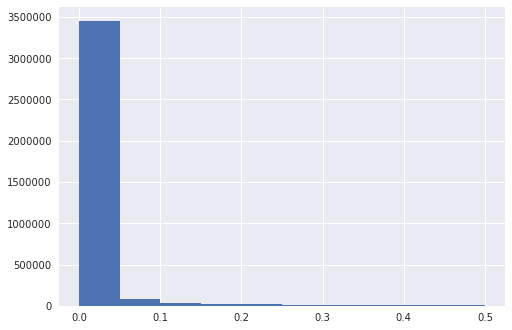

In [150]:
plt.hist(maf_before)

Text(0.5, 0.98, 'MAF of SNPs of BFcol.3R before minor allel filtering')

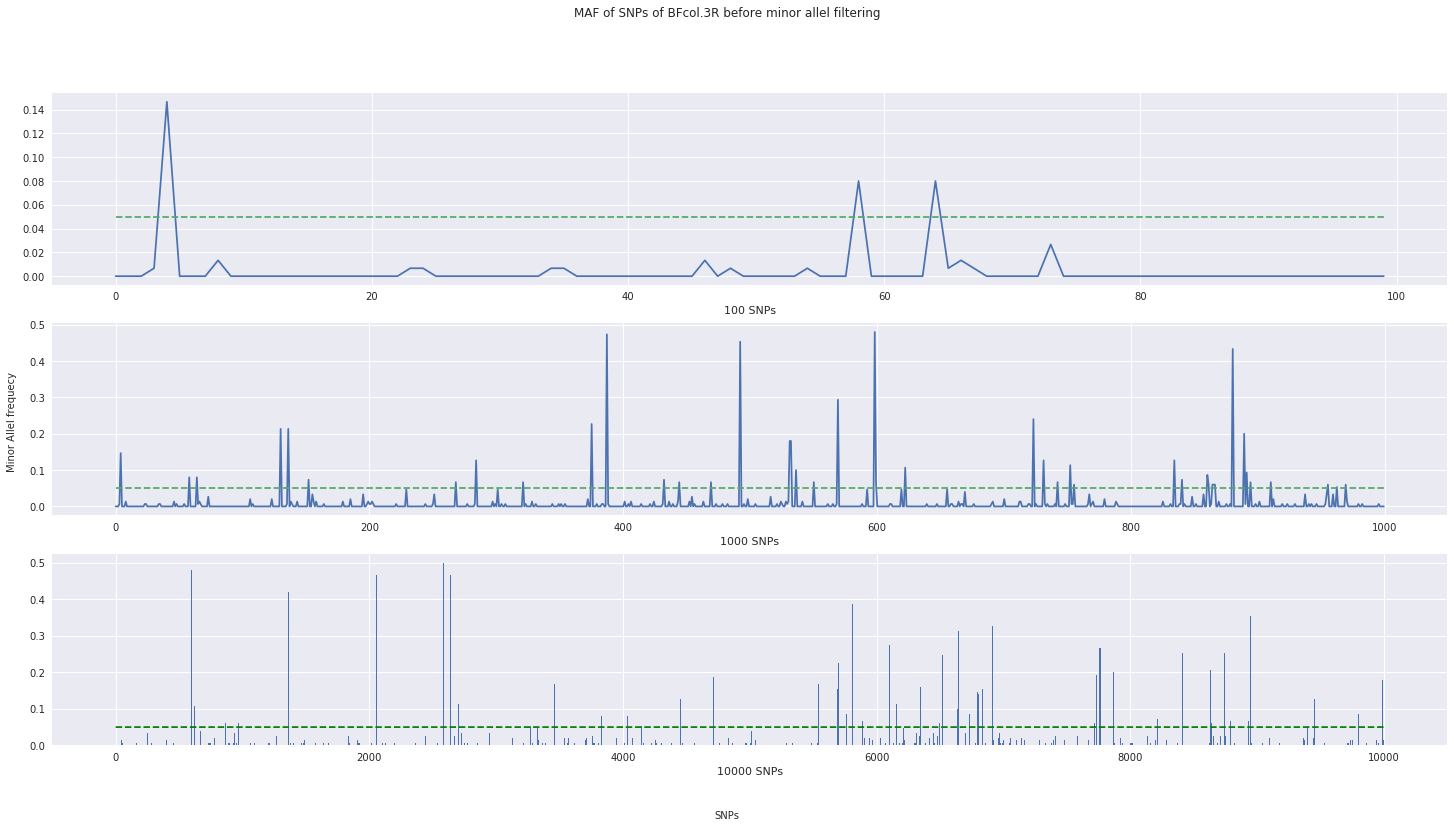

In [81]:
x = range(0,len(maf_before))

plt.style.use('seaborn')
fig, ax = plt.subplots(3, 1,figsize=(25,12))
ax[0].plot(x[:100],maf_before[:100])
ax[0].plot(x[:100],[0.05]*100,linestyle='dashed')
ax[1].plot(x[:1000],maf_before[:1000])
ax[1].plot(x[:1000],[0.05]*1000,linestyle='dashed')
ax[2].bar(x[:10000],maf_before[:10000])
ax[2].plot(x[:10000],[0.05]*10000,linestyle='dashed',color='g')

ax[0].set_xlabel('100 SNPs')
ax[1].set_xlabel('1000 SNPs')
ax[2].set_xlabel('10000 SNPs')
fig.text(0.5, 0.04, 'SNPs', ha='center')
fig.text(0.1, 0.5, 'Minor Allel frequecy', va='center', rotation='vertical')
fig.suptitle(f'MAF of SNPs of {pop_name} before minor allel filtering')

Text(0.5, 0.98, 'MAF of SNPs of BFcol.3R after filtering minor allel at each SNP')

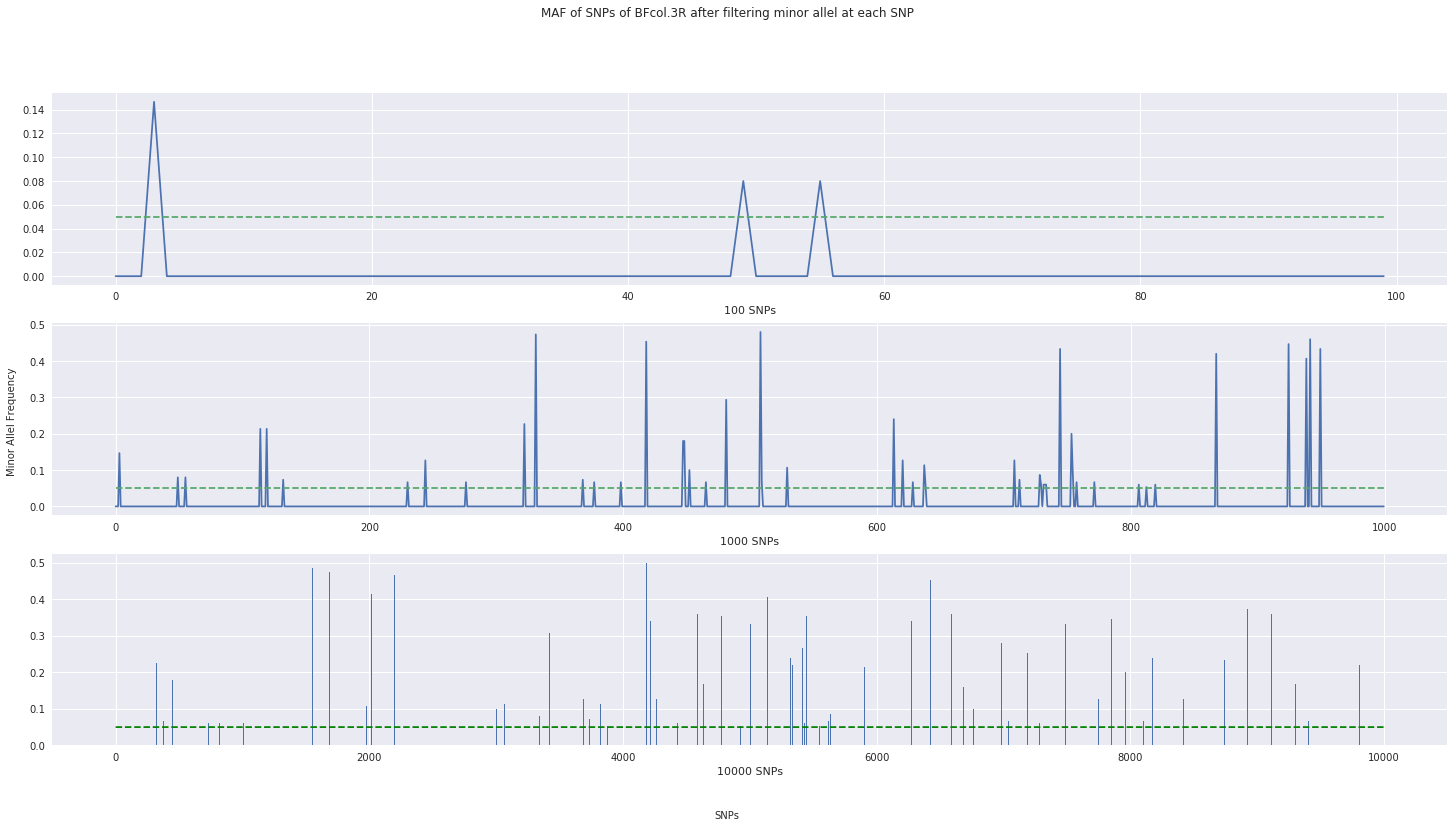

In [82]:
x = range(0,len(maf_after))[:10000]


plt.style.use('seaborn')
fig, ax = plt.subplots(3, 1,figsize=(25,12))
ax[0].plot(x[:100],maf_after[:100])
ax[0].plot(x[:100],[0.05]*100,linestyle='dashed')
ax[1].plot(x[:1000],maf_after[:1000])
ax[1].plot(x[:1000],[0.05]*1000,linestyle='dashed')
ax[2].bar(x[:10000],maf_after[:10000])
ax[2].plot(x[:10000],[0.05]*10000,linestyle='dashed',color='g')

ax[0].set_xlabel('100 SNPs')
ax[1].set_xlabel('1000 SNPs')
ax[2].set_xlabel('10000 SNPs')
fig.text(0.5, 0.04, 'SNPs', ha='center')
fig.text(0.1, 0.5, 'Minor Allel Frequency', va='center', rotation='vertical')
fig.suptitle(f'MAF of SNPs of {pop_name} after filtering minor allel at each SNP')

Text(0.5, 1.0, 'MAF Histogram after MAF filtering')

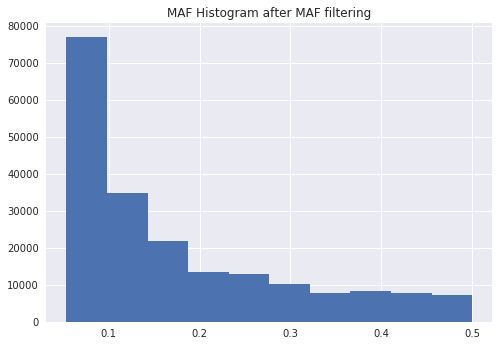

In [151]:
plt.hist(maf_after)
plt.title('MAF Histogram after MAF filtering')

### LD Pruning (Alistair's Method)

In [176]:
'''
Params : 
gn = Haplotype Matrix
size = window size to be consdered for LD calculation and pruning
step = overlap size between windows
threshold = Maximum value of r**2 to include variants. 
'''

def ld_pruning(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn

In [177]:
# Takes a long long time on 2.7M SNP
# After filtering lesser are there ~202K in BFcol
# Threshold = 0.1
gnu = ld_pruning(haplotypeF, size=500, step=100, threshold=.1, n_iter=2)

iteration 1 retaining 94486 removing 107107 variants
iteration 2 retaining 85815 removing 8671 variants


In [190]:
BFcol_haploF = gnu.copy()
BFcol_haploF.shape

(85815, 150)

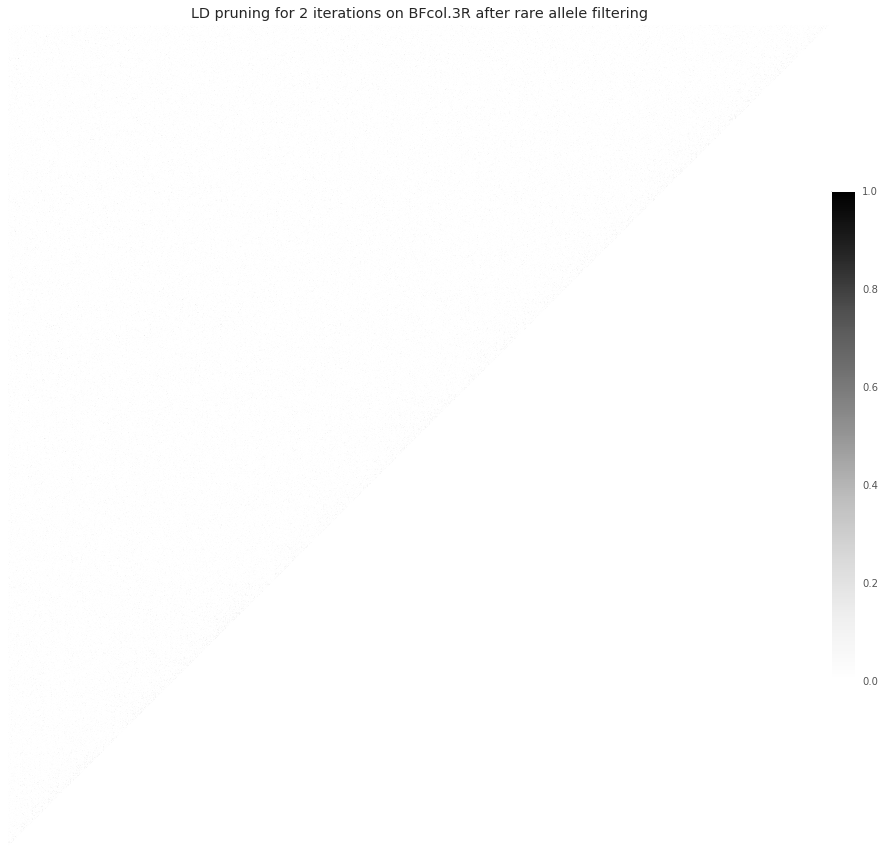

In [188]:
plot_ld(BFcol_haploF[:1000],'LD pruning for 2 iterations on BFcol.3R after rare allele filtering')

In [25]:
# For the time being, taking random 1% of MAF filtered SNP's
rindexes = np.random.randint(len(haplotypeF),size=int((len(haplotypeF)*0.01)))
haplotypeFF = haplotypeF[rindexes]
haplotypeFF.shape

(27979, 150)

### Generic Filtering Functions

In [218]:
'''
Requirements : NumPy and Scikit-Allel
'''

class FilterSNP():
    def __init__(self,haplotype, POS):
        self.haplotype = haplotype
        self.POS = POS
        self.H = haplotype
        self.P = POS
        self._removed_maf = None
        self._retained_maf = None
        self._retained_ld = None
        self._removed_ld = None
        
    def all_filters(self, LD_window_size, LD_overlap_step, MBP_start = 1, MBP_end = 37, MAF_threshold = 5, LD_threshold=.1,LD_iter=1):
        print("1.) Selecting Mega Base Pairs")
        self.H,self.P = self.get_haplo_MBP(self.H,self.P,start = MBP_start, end = MBP_end)
        print("MBP selected. Retained Matrix = ", self.H.shape)
        print("2.) Filtering Rare Allels")
        self.H,self.P = self.filter_MAF(self.H,self.P,threshold = MAF_threshold)
        print("3.) Performing LD Pruning")
        self.H = self.LD_pruning(self.H, LD_window_size, LD_overlap_step, threshold = LD_threshold, n_iter = LD_iter)
        print("Retained Matrix = ", self.H.shape)
        
        return self.H, self.P

    def filter_MAF(self,haplo,POS,threshold = 5):
        if threshold >= 50 : 
            print("MAF threshold cannot be more than 49%")
            return
        samples = haplo.shape[1]
        sums = haplo.sum(axis=1)
        maf = get_MAF(haplo)
        #indexes = np.where(maf >= threshold*0.01)[0]
        minor = samples*threshold/100
        major = samples*(100-threshold)/100
        # Selects indexes where allels are >threshold or all 0 and all 1.
        indexes = np.where((sums>=minor)& (sums<=major))[0]
        print("Number of SNPs removed = ",len(haplo)-len(indexes))
        print("Retaining = ",len(indexes))
        self._removed_maf = len(haplo)-len(indexes)
        self._retained_maf = len(indexes)
        return np.take(haplo,indexes,0), np.take(POS,indexes,0)

    # Returns : Array of MAF
    def get_MAF(self,haplo):
        samples = haplo.shape[1]
        sums = haplo.sum(axis=1)
        maf = []
        for s in sums:
            if s != samples or s != 0:
                frequency = s/samples
                if frequency > 0.5:
                    maf.append(1-frequency)
                else: 
                    maf.append(frequency)
        return np.array(maf)

    def get_MBP(self,POS,start = 1,end = 37):
        return np.where(POS[np.where(POS>=1e6)]<=37e6)[0]

    def get_haplo_MBP(self,haplotype,POS,start = 1,end = 37):
        index = get_MBP(POS,start,end)
        return np.take(haplotype,index,0),np.take(POS,index,0)
    
    def LD_pruning(self,gn, size, step, threshold = .1, n_iter=1):
        removed = 0
        for i in range(n_iter):
            loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
            n = np.count_nonzero(loc_unlinked)
            n_remove = gn.shape[0] - n
            removed += n_remove
            print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
            gn = gn.compress(loc_unlinked, axis=0)
        self._retained_ld = gn.shape[0]
        self._removed_ld = removed
        return gn

In [383]:
'''
Disclaimer : The class is for personal use. It is not aimed for portability or reusability.

Class to load and filter the data from disk.
Object Parameters : 
data_path  -> Path to the data directory

load_pop() : Function to load the data
params : 
Populations -> list or array of population names/filenames
filtered -> boolean, whethere to filter the data or not
combine -> Boolean, to combine the populations (Implement it !!!)

returns : A dictionary of haplotype matrix and Position array
'''

class LoadFilteredPops():
    def __init__(self,data_path = None):
        self.data_path = data_path
        
    def load_pop(self,populations,naming='custom',chromo_arms = ['3R'], combine = False, filtered = True):
        if self.data_path is None:
            home = os.path.expanduser('~')
            directory = os.path.join('Imp_Research','Dataset')
        if combine
        Haplo_pop = {}
        POS_pop = {}
        for population in populations:
            for arm in chromo_arms:
                pop_name = population+'.'+arm
                if naming == 'custom':
                    filename = f'Haplotype.POS.{pop_name}.hd5'
                else:
                    filename = population
                if self.data_path is None:
                    data_path = os.path.join(home, directory,"HDF_Dataset", filename)
                else:
                    try:
                        data_path = os.path.join(self.data_path,filename)
                    except:
                        print("Cannot resolve Directory path")
                        exit()
                print(f'------{pop_name}------\n')
                H = pd.read_hdf(data_path,key='Haplotype').astype('int8').to_numpy().astype('int8')
                P = pd.read_hdf(data_path,key='POS').to_numpy()
                
                if filtered:
                    datafilter = FilterSNP(H,P)
                    Haplo_pop[pop_name],POS_pop[pop_name] = datafilter.all_filters(LD_window_size = 500,LD_overlap_step = 100,LD_iter = 3)
                else: 
                    Haplo_pop[pop_name],POS_pop[pop_name] = H,P
                del H,P     
        print("Populations loaded !!!")
        return Haplo_pop,POS_pop
        

In [468]:
'''
Function to combine the populations
Params
Haplo_all : Dictionary containing Haplotype matrix for populations. Key-> pop name; Value -> matrix.
            Matrix dimensions must be POS x haplotypes.
POS_all : Position array of SNPs
filtered : Boolean, to filter after combining or not.
get_labels : Boolean, to generate labels

returns
Haplo_all : ndarray of n x m dimensions. n = length of POS array; m = sum of haplotypes from all populations.
POS : SNP Position array
labels : list of labels if Labels = []
'''

def combine_pops(H_all,P_all,filtered = True,get_labels = True):
    keys = list(H_all.keys())
    H = np.array(H_all[keys[0]])
    if len(H_all) > 1:
        for i in range(1,len(H_all)):
            H = np.append(H,H_all[keys[i]],axis=1)
    print('Combined Shape => ',H.shape)
    if get_labels:
        label = []
        for each in keys:
            label.extend([each[:-3]]*len(H_all[each][0]))
    if filtered == False:
        if get_labels:
            return H,P_all,label
        else:
            return H,p_all
    else:
        datafilter = FilterSNP(H,P_all)
        H_filtered,POS_filtered = datafilter.all_filters(LD_window_size = 500,LD_overlap_step = 100,LD_iter = 3)
        print('Filtered Shape => ',H_filtered.shape)
        if get_labels:
            return H_filtered,POS_filtered,label
        else:
            return H_filtered,POS_filtered
        

#### Filtering the populations

In [242]:
# populations = ['BFcol','BFgam','AOcol','CIcol','CMgam','FRgam',
#               'GAgam','GHcol','GHgam','GM','GNcol','GNgam','GQgam',
#               'GW','KE','UGgam']

populations = ['GNgam','KE','UGgam']

# Taking only arm 3R
chromo_arms = ['3R']

# Dic. Stores all the filtered populations
# POS_pop = {} has ['GNgam','KE','UGgam']
# Haplo_pop = {} has ['GNgam','KE','UGgam']

# Haplo_all = {}
# POS_all = {}
Haplo_pop = {}
POS_pop = {}

for population in populations:
    for arm in chromo_arms:
        pop_name = population+'.'+arm
        filename = f'Haplotype.POS.{pop_name}.hd5'
        data_path = os.path.join(home, directory,"HDF_Dataset", filename)
    
        print(f'------{pop_name}------\n')
        H = pd.read_hdf(data_path,key='Haplotype').astype('int8').to_numpy().astype('int8')
        P = pd.read_hdf(data_path,key='POS').to_numpy()
        
        datafilter = FilterSNP(H,P)
        data_H,data_P = datafilter.all_filters(LD_window_size = 500,LD_overlap_step = 100,LD_iter = 3)
        del H,P
        Haplo_pop[pop_name] = data_H
        POS_pop[pop_name] = data_P
        del data_H,data_P

------GNgam.3R------

1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 80)
2.) Filtering Rare Allels
Number of SNPs removed =  3417049
Retaining =  234671
3.) Performing LD Pruning
iteration 1 retaining 53663 removing 181008 variants
iteration 2 retaining 22593 removing 31070 variants
iteration 3 retaining 11594 removing 10999 variants
Retained Matrix =  (11594, 80)
------KE.3R------

1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 96)
2.) Filtering Rare Allels
Number of SNPs removed =  3522483
Retaining =  129237
3.) Performing LD Pruning
iteration 1 retaining 916 removing 128321 variants
iteration 2 retaining 162 removing 754 variants
iteration 3 retaining 143 removing 19 variants
Retained Matrix =  (143, 96)
------UGgam.3R------

1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 224)
2.) Filtering Rare Allels
Number of SNPs removed =  3443450
Retaining =  208270
3.) Performing LD Pruning
iteration 1 retaining 95

#### Storing Filtering Stats for all populations

In [232]:
populations = ['BFcol','BFgam','AOcol','CIcol','CMgam','FRgam',
              'GAgam','GHcol','GHgam','GM','GNcol','GNgam','GQgam',
              'GW','KE','UGgam']

# Taking only arm 3R
chromo_arms = ['3R']

# Storing : Pop Name, Initial Shape, SNPs Removed in Rare Allele Filtering, RAF Retained Shape, Removed in LD Pruning, Final Shape

columns = ['Population', 'Haplotypes', 'Initial_SNP', 'SNPs_removed_MAF', 'MAF_retained_shape','SNPs_removed_LD','Final_shape']
Filtering_stats = pd.DataFrame(columns = columns)

for population in populations:
    for arm in chromo_arms:
        stats = []
        pop_name = population+'.'+arm
        filename = f'Haplotype.POS.{pop_name}.hd5'
        data_path = os.path.join(home, directory,"HDF_Dataset", filename)
    
        print(f'------{pop_name}------\n')
        
        H = pd.read_hdf(data_path,key='Haplotype').astype('int8').to_numpy().astype('int8')
        P = pd.read_hdf(data_path,key='POS').to_numpy()
        
        stats.append(pop_name)
        stats.append(H.shape[1])
        stats.append(H.shape[0])
        datafilter = FilterSNP(H,P)

#       Window = 500, Overlap = 100, Iteration = 3
        data_H,data_P = datafilter.all_filters(LD_window_size = 500,LD_overlap_step = 100,LD_iter = 3)

        stats.append(datafilter._removed_maf)
        stats.append(datafilter._retained_maf)
        stats.append(datafilter._removed_ld)
        stats.append(data_H.shape[0])
        
#         Filtering_stats = Filtering_stats.append(pd.DataFrame([stats],columns = columns), ignore_index=True)
        Filtering_stats.loc[len(Filtering_stats)] = stats
    
        del data_H,data_P
        del H,P, datafilter

------BFcol.3R------

1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 150)
2.) Filtering Rare Allels
Number of SNPs removed =  3450127
Retaining =  201593
3.) Performing LD Pruning
iteration 1 retaining 94486 removing 107107 variants
iteration 2 retaining 85815 removing 8671 variants
iteration 3 retaining 84145 removing 1670 variants
Retained Matrix =  (84145, 150)
------BFgam.3R------

1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 184)
2.) Filtering Rare Allels
Number of SNPs removed =  3448322
Retaining =  203398
3.) Performing LD Pruning
iteration 1 retaining 98612 removing 104786 variants
iteration 2 retaining 93379 removing 5233 variants
iteration 3 retaining 92807 removing 572 variants
Retained Matrix =  (92807, 184)
------AOcol.3R------

1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 156)
2.) Filtering Rare Allels
Number of SNPs removed =  3458829
Retaining =  192891
3.) Performing LD Pruning
iteration

In [233]:
Filtering_stats

Population Haplotypes Initial_SNP SNPs_removed_MAF MAF_retained_shape  \
0    BFcol.3R        150     4836295          3450127             201593   
1    BFgam.3R        184     4836295          3448322             203398   
2    AOcol.3R        156     4836295          3458829             192891   
3    CIcol.3R        142     4836295          3441774             209946   
4    CMgam.3R        594     4836295          3447255             204465   
5    FRgam.3R         48     4836295          3513224             138496   
6    GAgam.3R        138     4836295          3415632             236088   
7    GHcol.3R        110     4836295          3435533             216187   
8    GHgam.3R         24     4836295          3447234             204486   
9       GM.3R        130     4836295          3420635             231085   
10   GNcol.3R          8     4836295          3464195             187525   
11   GNgam.3R         80     4836295          3417049             234671   
12   GQgam.3R         18     4836295          3340160             311560   
13      GW.3R        182     4836295          3442758             208962   
14      KE.3R         96     4836295          3522483             129237   
15   UGgam.3R        224     4836295          3443450             208270   

   SNPs_removed_LD Final_shape  
0           117448       84145  
1           110591       92807  
2           181052       11839  
3           173101       36845  
4            89849      114616  
5           138370         126  
6           232280        3808  
7           189816       26371  
8           204378         108  
9           213942       17143  
10          187518           7  
11          223077       11594  
12          311509          51  
13          126202       82760  
14          129094         143  
15          115309       92961

In [234]:
Filtering_stats.to_csv('Filtering_Statistics.csv')

In [236]:
import pickle 
with open('Haplotype_Filtered_Population_Data.pkl','wb') as file:
    pickle.dump(Haplo_pop,file)

with open('POS_Filtered_Population_Data.pkl','wb') as file:
    pickle.dump(POS_pop,file)

#### Filtering the populations together
##### (KE, UGgam and GNgam)

In [250]:
# populations = ['BFcol','BFgam','AOcol','CIcol','CMgam','FRgam',
#               'GAgam','GHcol','GHgam','GM','GNcol','GNgam','GQgam',
#               'GW','KE','UGgam']

populations = ['GNgam','KE','UGgam']

# Taking only arm 3R
chromo_arms = ['3R']

H_all = []
P_all = []

for population in populations:
    for arm in chromo_arms:
        pop_name = population+'.'+arm
        filename = f'Haplotype.POS.{pop_name}.hd5'
        data_path = os.path.join(home, directory,"HDF_Dataset", filename)
    
        print(f'------{pop_name}------\n')
        H = pd.read_hdf(data_path,key='Haplotype').astype('int8').to_numpy().astype('int8')
        P = pd.read_hdf(data_path,key='POS').to_numpy()
        
        H_all.append(H)
        P_all.append(P)

------GNgam.3R------

------KE.3R------

------UGgam.3R------



In [253]:
H = np.array(H_all[0])

In [259]:
H = np.append(H,H_all[1],axis=1)
H = np.append(H,H_all[2],axis=1)

In [260]:
H.shape

(4836295, 400)

In [263]:
P = np.array(P_all[0])
P.shape

(4836295, 1)

In [264]:
# Filtering KN, UGgam and GNgam together
datafilter = FilterSNP(H,P)
H_filtered, P_filtered = datafilter.all_filters(LD_window_size = 500,LD_overlap_step = 100,LD_iter = 3)

1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 400)
2.) Filtering Rare Allels
Number of SNPs removed =  3440180
Retaining =  211540
3.) Performing LD Pruning
iteration 1 retaining 72683 removing 138857 variants
iteration 2 retaining 68085 removing 4598 variants
iteration 3 retaining 67780 removing 305 variants
Retained Matrix =  (67780, 400)


### Some Preliminary Plots

In [266]:
# PCA of jointly filtered populations = KE, UGgam and GNgam
coords1, model1 = allel.pca(H_filtered, n_components=10, scaler='patterson')

pop_colours = {
    'BFcol': '#FF0000',
    'GAgam': '#008000',
    'GNgam': '#00FFFF',
    'UGgam': '#90EE90',
    'AOcol': '#8B0000',
    'BFgam': '#1E90FF',
    'KE': '#808080',
}
# populations = ['BFcol','BFgam','AOcol','CIcol','CMgam','FRgam',
#               'GAgam','GHcol','GHgam','GM','GNcol','GNgam','GQgam',
#               'GW','KE','UGgam']

In [309]:
# creating population tag in same order as combined Haplotype matrix to recognize each sample

sample = ['GNgam']*80
sample.extend(['KE']*96)
sample.extend(['UGgam']*224)

labels = [0]*80
labels.extend([1]*96)
labels.extend([2]*224)
labels = np.array(labels)

In [293]:
sample_population = np.array(sample)
sample_population.shape

(400,)

In [294]:
def plot_pca_coords(coords, model, pc1, pc2, ax, sample_population):
    sns.despine(ax=ax, offset=5)
    x = coords[:, pc1]
    y = coords[:, pc2]
    populations = ['GNgam','KE','UGgam']
    for pop in populations:
        flt = (sample_population == pop)
        ax.plot(x[flt], y[flt], marker='o', linestyle=' ', color=pop_colours[pop], 
                label=pop, markersize=6, mec='k', mew=.5)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    

def fig_pca(coords, model, title, sample_population):
    # plot coords for PCs 1 vs 2, 3 vs 4
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 2, 1)
    plot_pca_coords(coords, model, 0, 1, ax, sample_population)
    ax = fig.add_subplot(1, 2, 2)
    plot_pca_coords(coords, model, 2, 3, ax, sample_population)
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    fig.suptitle(title, y=1.02)
    fig.tight_layout()

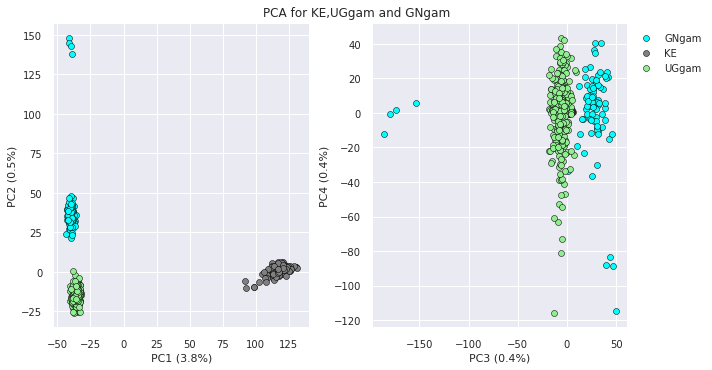

In [297]:
# Sample_population variable takes in name of population for each sample in haplotype matrix in same order
plt.style.use('seaborn')
fig_pca(coords1, model1, 'PCA for KE,UGgam and GNgam',sample_population=sample_population)

#### UMAP for GNgam, KE, UGgam

In [339]:
from sklearn.preprocessing import StandardScaler
H_FiltSScaled = StandardScaler().fit_transform(H_filtered)
H_FiltPScaled = allel.PattersonScaler().fit_transform(H_filtered)

In [371]:
import umap.umap_ as umap

H_FiltPScaled = allel.PattersonScaler().fit_transform(H_filtered)

# Patterson Scaled Unsupervised UMAP
UMAP_haplo = umap.UMAP(n_neighbors=5).fit_transform(H_FiltPScaled.T)

# Patterson scaled Supervised UMAP
UMAP_haplo_S = umap.UMAP(n_neighbors=5).fit_transform(H_FiltPScaled.T,y = labels)

Text(0.5, 1.0, 'Supervised UMAP')

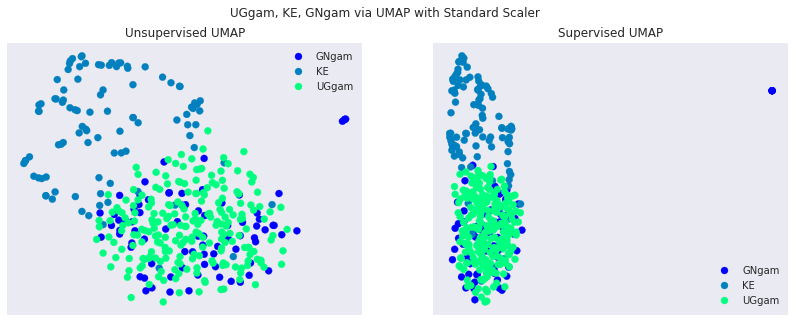

In [370]:
populations = ['GNgam','KE','UGgam']
fig, ax = plt.subplots(1,2, figsize=(14, 5))
# plt.scatter(*embedding.T, s=0.3, c=pop_colors, cmap='Spectral', alpha=1.0)
sc1 = ax[0].scatter(
      UMAP_haplo[:, 0],
      UMAP_haplo[:, 1],
      c=labels,cmap='winter')
sc2 = ax[1].scatter(
      UMAP_haplo_S[:, 0],
      UMAP_haplo_S[:, 1],
      c=labels,cmap='winter')
ax[0].legend(handles=sc1.legend_elements()[0], labels=populations)
ax[1].legend(handles=sc2.legend_elements()[0], labels=populations)
plt.setp(ax, xticks=[], yticks=[])
plt.suptitle('UGgam, KE, GNgam with Standard Scaler via UMAP');
ax[0].set_title('Unsupervised UMAP')
ax[1].set_title('Supervised UMAP')

Text(0.5, 1.0, 'Supervised UMAP')

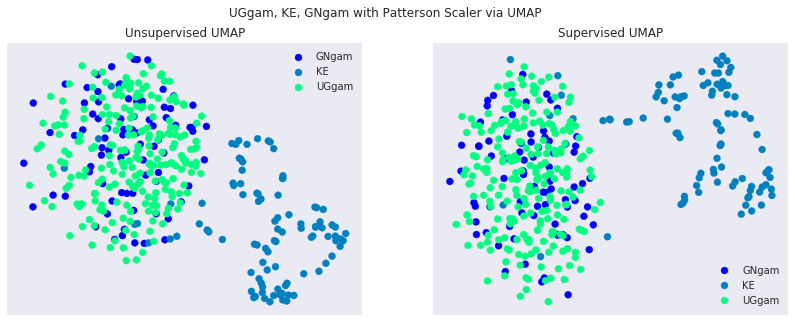

In [372]:
populations = ['GNgam','KE','UGgam']
fig, ax = plt.subplots(1,2, figsize=(14, 5))
# plt.scatter(*embedding.T, s=0.3, c=pop_colors, cmap='Spectral', alpha=1.0)
sc1 = ax[0].scatter(
      UMAP_haplo[:, 0],
      UMAP_haplo[:, 1],
      c=labels,cmap='winter')
sc2 = ax[1].scatter(
      UMAP_haplo_S[:, 0],
      UMAP_haplo_S[:, 1],
      c=labels,cmap='winter')
ax[0].legend(handles=sc1.legend_elements()[0], labels=populations)
ax[1].legend(handles=sc2.legend_elements()[0], labels=populations)
plt.setp(ax, xticks=[], yticks=[])
plt.suptitle('UGgam, KE, GNgam with Patterson Scaler via UMAP');
ax[0].set_title('Unsupervised UMAP')
ax[1].set_title('Supervised UMAP')

### PCA : Anopheles Gambiae vs Coluzzii

In [382]:
populations = ['BFcol','BFgam','AOcol','CIcol','CMgam','FRgam',
              'GAgam','GHcol','GHgam','GM','GNcol','GNgam','GQgam',
              'GW','KE','UGgam']
loader = LoadFilteredPops()
Haplo_all, POS_all = loader.load_pop(populations,filtered = False)

------BFcol.3R------

------BFgam.3R------

------AOcol.3R------

------CIcol.3R------

------CMgam.3R------

------FRgam.3R------

------GAgam.3R------

------GHcol.3R------

------GHgam.3R------

------GM.3R------

------GNcol.3R------

------GNgam.3R------

------GQgam.3R------

------GW.3R------

------KE.3R------

------UGgam.3R------



In [399]:
Haplo_all.keys()

dict_keys(['BFcol.3R', 'BFgam.3R', 'AOcol.3R', 'CIcol.3R', 'CMgam.3R', 'FRgam.3R', 'GAgam.3R', 'GHcol.3R', 'GHgam.3R', 'GM.3R', 'GNcol.3R', 'GNgam.3R', 'GQgam.3R', 'GW.3R', 'KE.3R', 'UGgam.3R'])

In [400]:
H_allF, POS_allF,pop_labels = combine_pops(Haplo_all,POS_all['BFcol.3R'])

1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 2284)
2.) Filtering Rare Allels
Number of SNPs removed =  3451543
Retaining =  200177
3.) Performing LD Pruning
iteration 1 retaining 117993 removing 82184 variants
iteration 2 retaining 117494 removing 499 variants
iteration 3 retaining 117461 removing 33 variants
Retained Matrix =  (117461, 2284)


In [401]:
hap = pd.DataFrame(H_allF).astype('int8')
pos = pd.DataFrame(POS_allF)
hap.to_hdf('Haplotype_Filtered_Combined_Population_Data.hd5',key='Haplotype',format='fixed',mode='w',complevel=9)
del hap
pos.to_hdf('POS_Filtered_Combined_Population_Data.hd5',key='POS',format='fixed',mode='a',complevel=9)
del pos

In [415]:
# Generating labels for Col vs Gam
dflabel = pd.DataFrame(pop_labels)
gam = ['BFgam','CMgam','FRgam','GAgam','GHgam','GM','GNgam','GQgam',
              'GW','KE','UGgam']
col = ['BFcol','AOcol','CIcol','GNcol']
dflabel[0] = dflabel[0].str[:-3]
dflabel.replace(gam,'gam',inplace=True)
dflabel.replace(col,'col',inplace=True)

labels_colgam = np.array(list(dflabel[0]))

In [467]:
# Loading and filtering BF col and gam

populations = ['BFcol','BFgam']
loader = LoadFilteredPops()
Haplo_BF, POS_BF = loader.load_pop(populations,filtered = False)
H_BF, POS_BF,bf_labels = combine_pops(Haplo_BF,POS_BF['BFcol.3R'])

------BFcol.3R------

------BFgam.3R------

Populations loaded !!!
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 334)
2.) Filtering Rare Allels
Number of SNPs removed =  3448792
Retaining =  202928
3.) Performing LD Pruning
iteration 1 retaining 117820 removing 85108 variants
iteration 2 retaining 116946 removing 874 variants
iteration 3 retaining 116906 removing 40 variants
Retained Matrix =  (116906, 334)


In [469]:
dfbflabel = pd.DataFrame(bf_labels)
dfbflabel[0] = dfbflabel[0].str[2:-3]
bf_labels = dfbflabel[0].to_numpy()

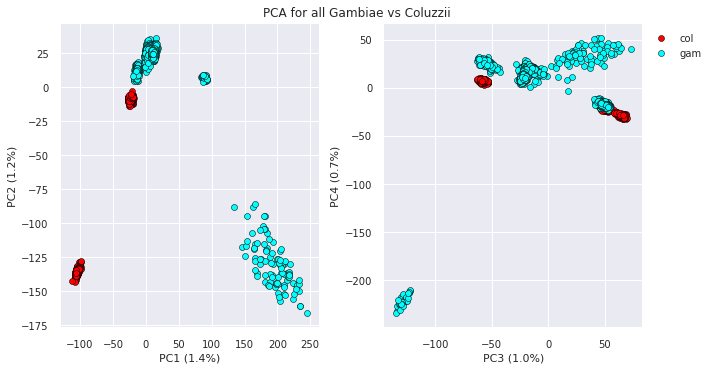

In [440]:
coords2, model2 = allel.pca(H_allF, n_components=10, scaler='patterson')

pop_colours = {
    'col': '#FF0000',
    'gam': '#00FFFF',
}
def plot_pca_coords(coords, model, pc1, pc2, ax, sample_population):
    sns.despine(ax=ax, offset=5)
    x = coords[:, pc1]
    y = coords[:, pc2]
    populations = ['col','gam']
    for pop in populations:
        flt = (sample_population == pop)
        ax.plot(x[flt], y[flt], marker='o', linestyle=' ', color=pop_colours[pop], 
                label=pop, markersize=6, mec='k', mew=.5)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    

def fig_pca(coords, model, title, sample_population):
    # plot coords for PCs 1 vs 2, 3 vs 4
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 2, 1)
    plot_pca_coords(coords, model, 0, 1, ax, sample_population)
    ax = fig.add_subplot(1, 2, 2)
    plot_pca_coords(coords, model, 2, 3, ax, sample_population)
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    fig.suptitle(title, y=1.02)
    fig.tight_layout()
    
plt.style.use('seaborn')
fig_pca(coords2, model2, 'PCA for all Gambiae vs Coluzzii',sample_population = labels_colgam)

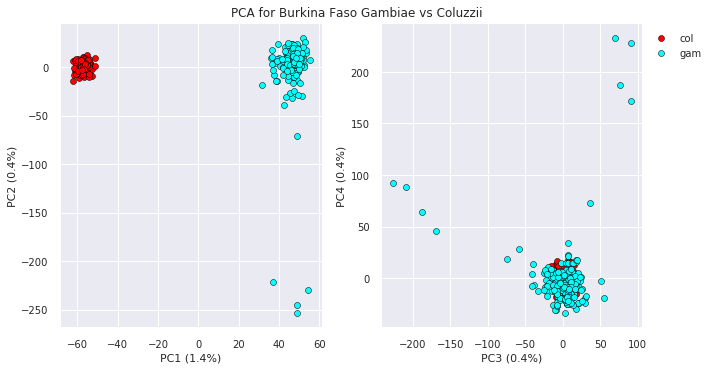

In [472]:
coords3, model3 = allel.pca(H_BF, n_components=10, scaler='patterson')
fig_pca(coords3, model3, 'PCA for Burkina Faso Gambiae vs Coluzzii',sample_population = bf_labels)

In [475]:
del Haplo_BF,POS_BF,UMAP_haplo,UMAP_haplo_S, H_filtered, H,P,H_all,P_all
del Haplo_pop,POS_pop

### UMAP for all the populations

In [487]:
populations = ['BFcol','BFgam','AOcol','CIcol','CMgam','FRgam',
              'GAgam','GHcol','GHgam','GM','GNcol','GNgam','GQgam',
              'GW','KE','UGgam']

labels_all = pd.DataFrame(pop_labels)
labels_all[0] = labels_all[0].str[:-3]
for i in range(len(populations)):
    labels_all[0].replace(populations[i],i,inplace=True)

In [492]:
labels_all = labels_all[0].to_numpy()

In [625]:
H_FiltScaledAll = allel.PattersonScaler().fit_transform(H_allF)

In [654]:
# Patterson Scaled Unsupervised UMAP

#UMAP_haplo = umap.UMAP(n_neighbors=50,metric='euclidean',min_dist=2,spread=5).fit_transform(H_FiltScaledAll.T)

UMAP_haplo = umap.UMAP(n_neighbors=15,metric='euclidean',min_dist=2,spread=5).fit_transform(H_allF.T)


# Hamming, n=50 is bad.
# Jaccard, n=50 is good.
# Dice, n=50 is average.

# Patterson scaled Supervised UMAP
#UMAP_haplo_S = umap.UMAP(n_neighbors=50,metric='jaccard').fit_transform(H_FiltScaledAll.T,y = labels_all)

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


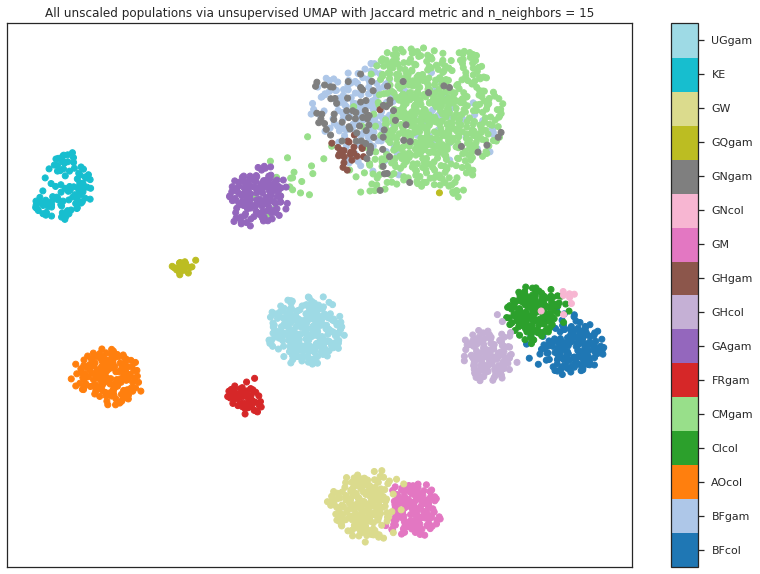

In [655]:
sns.set(style='white')
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(
      UMAP_haplo[:, 0],
      UMAP_haplo[:, 1],
      c=labels_all,cmap='tab20')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(17)-0.5)
cbar.set_ticks(np.arange(16))
cbar.set_ticklabels(populations)
plt.title('All unscaled populations via unsupervised UMAP with Jaccard metric and n_neighbors = 15');

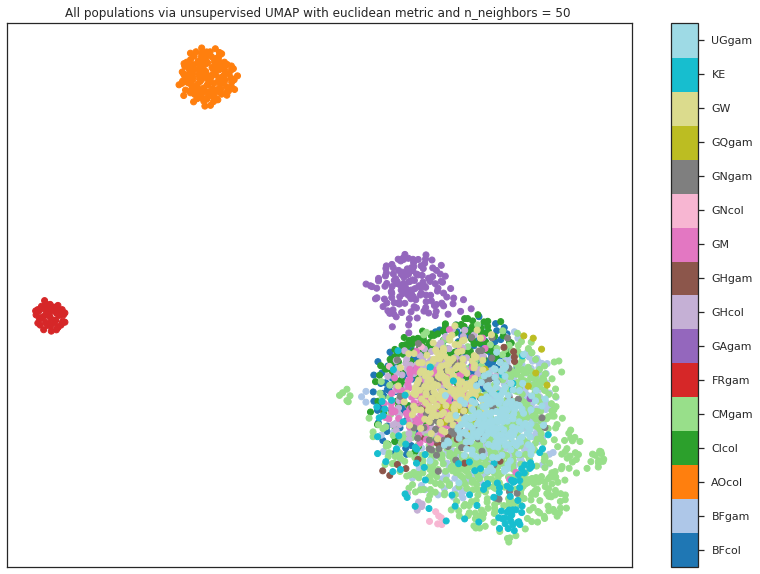

In [627]:
sns.set(style='white')
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(
      UMAP_haplo[:, 0],
      UMAP_haplo[:, 1],
      c=labels_all,cmap='tab20')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(17)-0.5)
cbar.set_ticks(np.arange(16))
cbar.set_ticklabels(populations)
plt.title('All populations via unsupervised UMAP with euclidean metric and n_neighbors = 50 ');

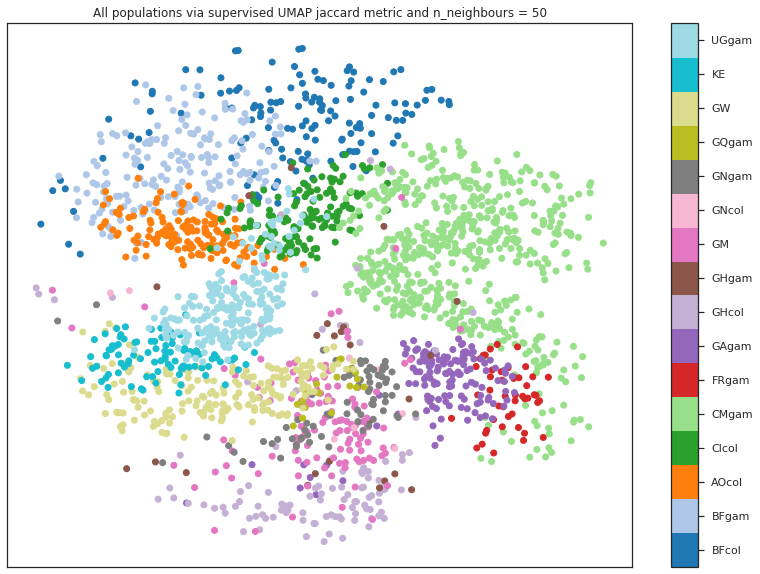

In [518]:

fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(
      UMAP_haplo_S[:, 0],
      UMAP_haplo_S[:, 1],
      c=labels_all,cmap='tab20')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(17)-0.5)
cbar.set_ticks(np.arange(16))
cbar.set_ticklabels(populations)
plt.title('All populations via supervised UMAP jaccard metric and n_neighbours = 50');

#### UMAP on balanced dataset
Removing GQgam, GHgam and GNcol

In [631]:
H_13 = H_allF.copy()

In [558]:
labels_13name = pd.DataFrame(pop_labels)
labels_13name[0] = labels_13name[0].str[:-3]
labels_13name = labels_13name.to_numpy()

In [559]:
remove_pop = np.where((labels_13name == ['GQgam','GHgam','GNcol']))
remove_pop[0].shape

(50,)

In [632]:
H_13Bal = np.delete(H_13,remove_pop,1)
H_13Bal.shape

(117461, 2231)

In [633]:
labels_13BalName = np.delete(labels_allname,remove_pop)
labels_13Bal = np.delete(labels_all,remove_pop)

In [634]:
# Balancing the samples by downsampling all to 50

import random
# 13 populations excluding GQgam, GHgam and GNcol
n_populations = [150,184,156,142,594,48,138,110,130,80,182,96,224]

Hbalanced = []
labels_b = []
labels_bname = []
i=0
balance_threshold = 48

for pop in n_populations:
    if pop < balance_threshold:
        Hbalanced.append(np.take(H_13Bal,range(i,i+pop),1))
        labels_b.extend(np.take(labels_13Bal,range(i,i+pop),0))
        labels_bname.extend(np.take(labels_13BalName,range(i,i+pop),0))
    else:
        rand_samp = random.sample(range(i,i+pop),balance_threshold)
        Hbalanced.append(np.take(H_13Bal,rand_samp,1))
        labels_b.extend(np.take(labels_13Bal,rand_samp,0))
        labels_bname.extend(np.take(labels_13BalName,rand_samp,0))
    i += pop

In [635]:
H_13balanced = np.array(Hbalanced[0])
for i in range(1,len(Hbalanced)):
    H_13balanced = np.append(H_13balanced,Hbalanced[i],1)

In [600]:
H_13balanced.shape

(117461, 624)

In [636]:
labels_13Bal = np.array(labels_b)
labels_13BalName = np.array(labels_bname)

In [652]:
#H_FiltScaledAll = allel.PattersonScaler().fit_transform(H_13balanced)
UMAP_haplo = umap.UMAP(n_neighbors=15,metric='dice',min_dist=2,spread=5).fit_transform(H_13balanced.T)

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


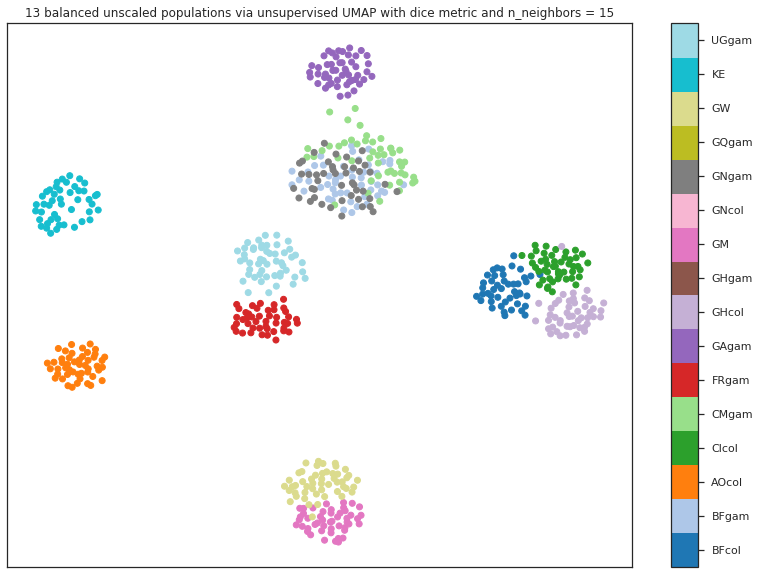

In [653]:
sns.set(style='white')
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(
      UMAP_haplo[:, 0],
      UMAP_haplo[:, 1],
      c=labels_13Bal,cmap='tab20')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(17)-0.5)
cbar.set_ticks(np.arange(16))
cbar.set_ticklabels(populations)
plt.title('13 balanced unscaled populations via unsupervised UMAP with dice metric and n_neighbors = 15');

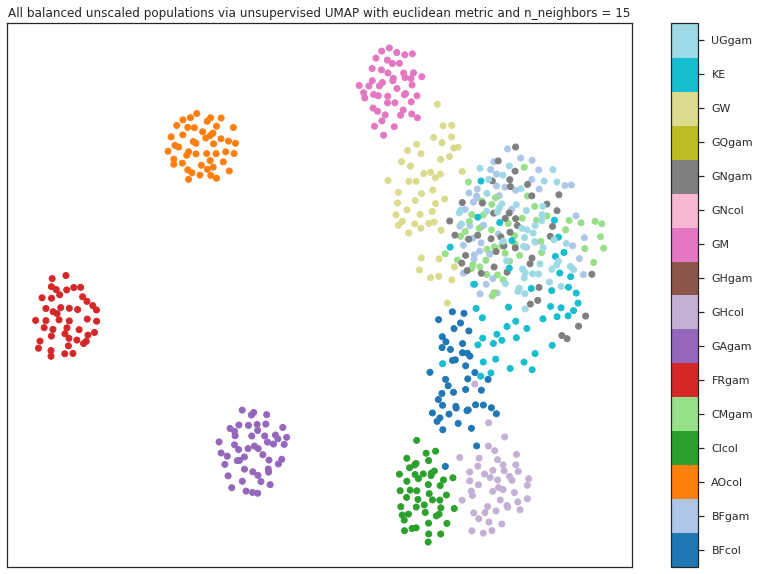

In [647]:
sns.set(style='white')
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(
      UMAP_haplo[:, 0],
      UMAP_haplo[:, 1],
      c=labels_13Bal,cmap='tab20')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(17)-0.5)
cbar.set_ticks(np.arange(16))
cbar.set_ticklabels(populations)
plt.title('All balanced unscaled populations via unsupervised UMAP with euclidean metric and n_neighbors = 15');

In [641]:
UMAP_haplo = umap.UMAP(n_neighbors=15,metric='euclidean',min_dist=2,spread=5).fit_transform(H_13balanced.T,y=labels_13Bal)

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


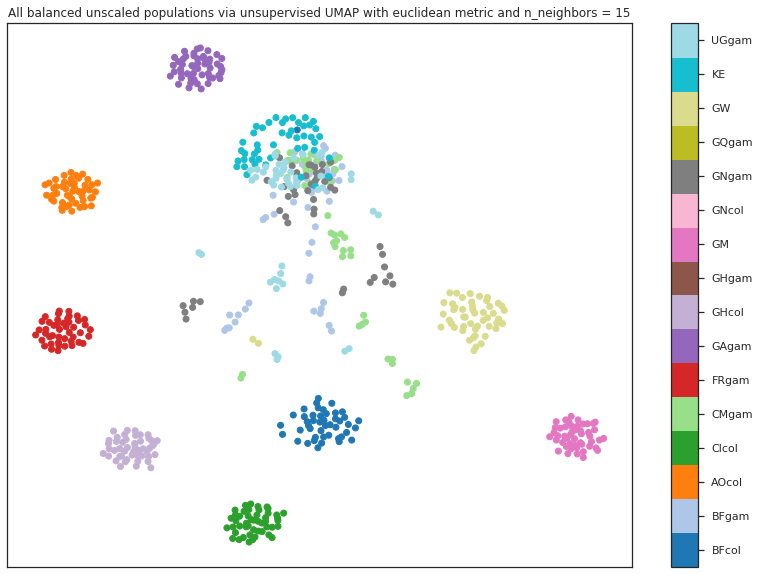

In [642]:
sns.set(style='white')
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(
      UMAP_haplo[:, 0],
      UMAP_haplo[:, 1],
      c=labels_13Bal,cmap='tab20')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(17)-0.5)
cbar.set_ticks(np.arange(16))
cbar.set_ticklabels(populations)
plt.title('All balanced unscaled populations via unsupervised UMAP with euclidean metric and n_neighbors = 15');

In [ ]:
# 3D UMAP using Babyplot
!pip install babyplots

In [718]:
#UMAP_haplo3D = umap.UMAP(n_components = 3,n_neighbors=15,metric='euclidean',min_dist=2,spread=5).fit_transform(H_13balanced.T,y=labels_13Bal)
UMAP_haplo3D_unsup = umap.UMAP(n_components = 3,n_neighbors=15,metric='euclidean',min_dist=2,spread=5).fit_transform(H_13balanced.T)

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


In [734]:
from babyplots import Babyplot

coords_sup = UMAP_haplo3D.tolist()
coords_unsup = UMAP_haplo3D_unsup.tolist()

bp_sup = Babyplot()
bp_sup.add_plot(coords_sup, "pointCloud", "categories", labels_13BalName.tolist(), 
            {'size':5,"shape": "sphere", "colorScale": "tab20", "showAxes": [True, True, True], 
            "axisLabels": ["PC 1", "PC 2", "PC 3"],'showLegend':True})
bp_unsup = Babyplot()
bp_unsup.add_plot(coords_unsup, "pointCloud", "categories", labels_13BalName.tolist(), 
            {'size':5,"shape": "sphere", "colorScale": "tab20", "showAxes": [True, True, True], 
            "axisLabels": ["PC 1", "PC 2", "PC 3"],'showLegend':True})


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [738]:
bp_sup.save_as_html('Supervised_3d_UMAP_plot',True,"Supervised 3D UMAP on 13 Populations")

In [737]:
bp_unsup.save_as_html('Unsupervised_3d_UMAP_plot',True,"Unsupervised 3D UMAP on 13 Populations")

In [739]:
bp_unsup

In [740]:
bp_sup